In [1]:
from res.workflow import WindOnshoreWorkflow
from res import windpower

import geokit as gk
import pandas as pd
import numpy as np
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

---
# Set data paths & constants

In [2]:
TESTDATA = join("..","testing","data")
MERRA_SOURCE = join(TESTDATA,"merra-like.nc4")
LAND_COVER_SOURCE = join(TESTDATA,"clc-aachen_clipped.tif")
GWA_SOURCE = join(TESTDATA,"gwa50-like.tif")
PLACEMENT_SOURCE = join(TESTDATA,"turbinePlacements.shp")

BATCH_SIZE = 20000 # Total number of turbines to simulate at once (best value depends on your pc)
JOBS = 4 # The number of concurrent jobs
VERBOSE = True # When True, progress will be printed as the function executes

def tsplot(r):
    plt.figure(figsize=(12,4))
    if isinstance(r, pd.Series):
        plt.plot(r, linewidth=2, color=(0,91/255,130/255))
    else:
        for col in r.columns:
            plt.plot(r[col], linewidth=0.8, color=(0,91/255,130/255))
    plt.tick_params(labelsize=15)
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("kWh", fontsize=18)
    plt.grid()
    plt.show()

---
# Simulate explicit locatons with a constant turbine and hub height

In [3]:
locs = [(5.98520,50.79725),
        (5.99469,50.79421),
        (5.99411,50.80094),
        (6.00475,50.78443),
        (6.00417,50.79116),
        (6.00360,50.79789),
        (6.01309,50.79485),
        (6.01251,50.80158),
        (6.02200,50.79853),
        (6.02142,50.80526),]

Starting at: 2017-12-06 15:16:38.467274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.00s
Convolving power curves at +0.21s
Initializing simulations at +1.09s
Simulating 1 groups at +1.09s
 0: Starting at +1.09s
 0: Finished 10 turbines +1.10s (769.23 turbines/sec)
Finished simulating 10 turbines (10 surviving) at +1.10s (9.07 turbines/sec)
Done at +1.10s!


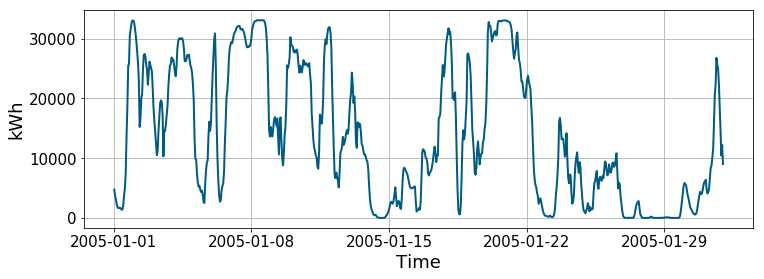

In [4]:
# Using a turine name from the TurbineLibrary
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, verbose=VERBOSE)

tsplot(result)

Starting at: 2017-12-06 15:16:39.686274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.00s
Convolving power curves at +0.07s
Initializing simulations at +0.95s
Simulating 1 groups at +0.95s
 0: Starting at +0.95s
 0: Finished 10 turbines +0.96s (1250.00 turbines/sec)
Finished simulating 10 turbines (10 surviving) at +0.96s (10.40 turbines/sec)
Done at +0.96s!


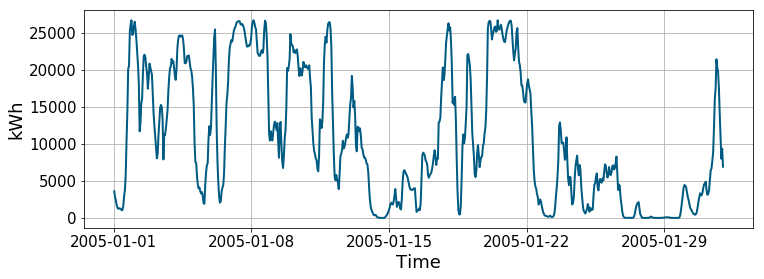

In [5]:
# Using a synthetic power curve
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             capacity=3000, rotordiam=120, hubHeight=100, 
                             verbose=VERBOSE)

tsplot(result)

---
# Remove low-output turbines

Starting at: 2017-12-06 15:16:40.765274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.00s
Convolving power curves at +0.07s
Initializing simulations at +0.96s
Simulating 1 groups at +0.96s
 0: Starting at +0.96s
 0: Finished 10 turbines +0.97s (1111.11 turbines/sec)
Finished simulating 10 turbines (4 surviving) at +0.97s (10.26 turbines/sec)
Done at +0.97s!


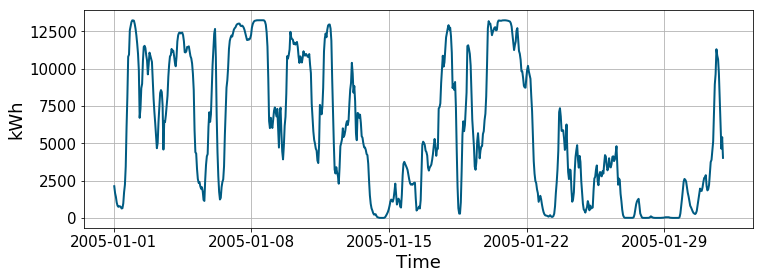

In [6]:
# turbines which have a capacity factor below 'minCF' are discarded
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, minCF=0.41,
                             verbose=VERBOSE)

tsplot(result)

---
# Various extraction methods
Options are:
* "totalProduction" -> Returns the total production at each timestep (DEFAULT)
* "averageProduction" -> Returns the average production at each timestep
* "capacityFactor" -> Returns the average capacity factor for each simulated turbine
* "raw"  -> Returns the complete time-series production for each simulated turbine
* "batch" -> Returns nothing, but if an output file is specified a "raw" output will be created for each batch

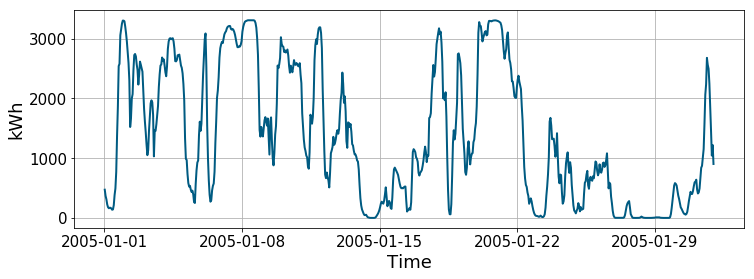

In [7]:
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, batchSize=BATCH_SIZE, jobs=JOBS, 
                             verbose=False, extract="averageProduction")
tsplot(result)

In [8]:
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, batchSize=BATCH_SIZE, jobs=JOBS, 
                             verbose=False, extract="raw")
result.iloc[:5,:5]

,"(5.98520,50.79725)","(5.99469,50.79421)","(5.99411,50.80094)","(6.00475,50.78443)","(6.00417,50.79116)"
2005-01-01 00:30:00+00:00,363.757215,496.871380,488.941853,293.819906,487.022931
2005-01-01 01:30:00+00:00,280.368448,388.009991,381.585878,224.092154,380.082040
2005-01-01 02:30:00+00:00,234.800841,328.244822,322.657455,186.186505,321.375793
2005-01-01 03:30:00+00:00,166.771765,238.279537,233.980171,130.074465,233.027074
2005-01-01 04:30:00+00:00,130.516817,189.670304,186.094097,100.552741,185.317560


In [9]:
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, batchSize=BATCH_SIZE, jobs=JOBS, 
                             verbose=False, extract="capacityFactor")
result.head()

(5.98520,50.79725)    0.352407
(5.99469,50.79421)    0.411743
(5.99411,50.80094)    0.408591
(6.00475,50.78443)    0.314547
(6.00417,50.79116)    0.407622
Name: capacityFactor, dtype: float64

---
# Simulate many locatons using multiple CPUs 

Starting at: 2017-12-06 15:16:52.768274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.05s
Convolving power curves at +1.16s
Initializing simulations at +2.06s
Simulating 4 groups at +2.14s
Finished simulating 10000 turbines (10000 surviving) at +4.50s (2220.74 turbines/sec)
Done at +4.50s!


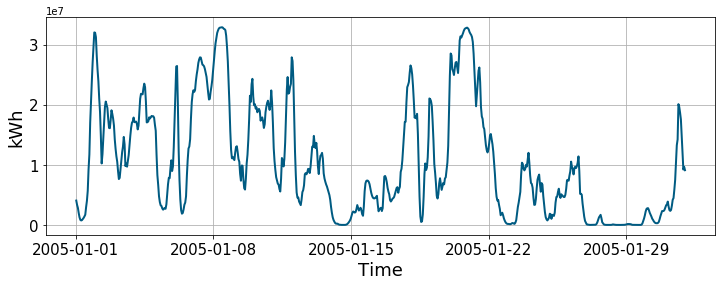

In [10]:
locs = np.column_stack([
    np.linspace(5.7,6.7,10000),  # 10,000 longitudes points
    np.linspace(50.4,51.0,10000) # 10,000 latitudes points
])


result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, verbose=VERBOSE, jobs=JOBS,
                             batchSize=BATCH_SIZE, )

tsplot(result)

---
# Simulate all locations given in a point-type vector file

Starting at: 2017-12-06 15:16:57.449274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.03s
Convolving power curves at +1.18s
Initializing simulations at +2.10s
Simulating 4 groups at +2.19s
Finished simulating 560 turbines (560 surviving) at +3.85s (145.34 turbines/sec)
Done at +3.85s!


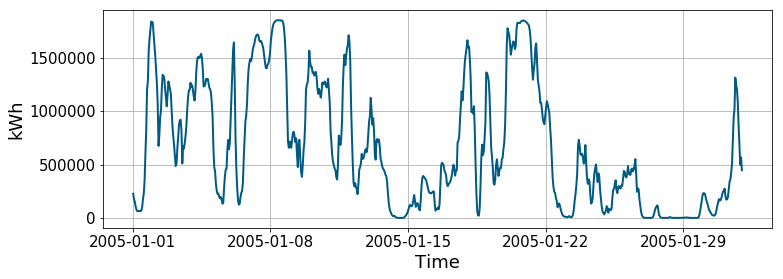

In [11]:
result = WindOnshoreWorkflow(PLACEMENT_SOURCE, merra=MERRA_SOURCE, gwa=GWA_SOURCE, 
                             landcover=LAND_COVER_SOURCE, powerCurve="V136-3450", hubHeight=100, 
                             batchSize=BATCH_SIZE, jobs=JOBS, verbose=VERBOSE)

tsplot(result)

---
# Filter locations before simulating

Starting at: 2017-12-06 15:17:15.654274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.00s
Convolving power curves at +1.10s
Initializing simulations at +1.99s
Simulating 4 groups at +2.07s
Finished simulating 280 turbines (280 surviving) at +3.41s (82.18 turbines/sec)
Done at +3.41s!


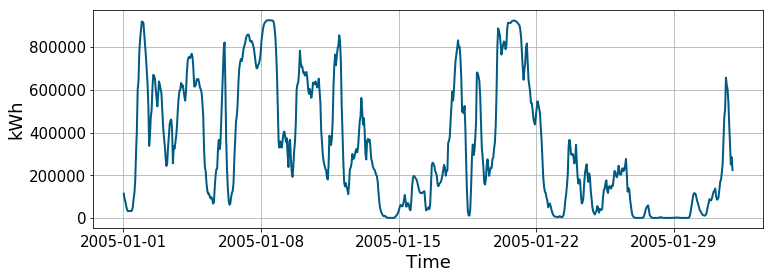

In [13]:
# Load placements into a dataframe
locs = gk.vector.extractAsDataFrame(PLACEMENT_SOURCE, outputSRS="latlon")

# Do whatever filtering you want...
locs = locs[::2]

# Simulate...
result = WindOnshoreWorkflow(locs, MERRA_SOURCE, powerCurve="V136-3450", hubHeight=100, 
                             gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE, jobs=JOBS,
                             batchSize=BATCH_SIZE)

tsplot(result)

---
# Unique definitions for each turbine

PLACEMENTS:
      lon       lat  hubHeight powerCurve
0  5.7000  50.40000    49.0000  E-126_EP4
1  5.7001  50.40006    49.0003  V136-3450
2  5.7002  50.40012    49.0006  E-126_EP4
3  5.7003  50.40018    49.0009  V136-3450
4  5.7004  50.40024    49.0012  E-126_EP4
5  5.7005  50.40030    49.0015  V136-3450
6  5.7006  50.40036    49.0018  E-126_EP4
7  5.7007  50.40042    49.0021  V136-3450
8  5.7008  50.40048    49.0024  E-126_EP4
9  5.7009  50.40054    49.0027  V136-3450

SIMULATION:
Starting at: 2017-12-06 15:17:19.259274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.06s
Convolving power curves at +1.12s
   Convolving 2 power curves...
Initializing simulations at +4.52s
Simulating 4 groups at +4.63s
Finished simulating 10000 turbines (10000 surviving) at +8.39s (1192.32 turbines/sec)
Done at +8.39s!


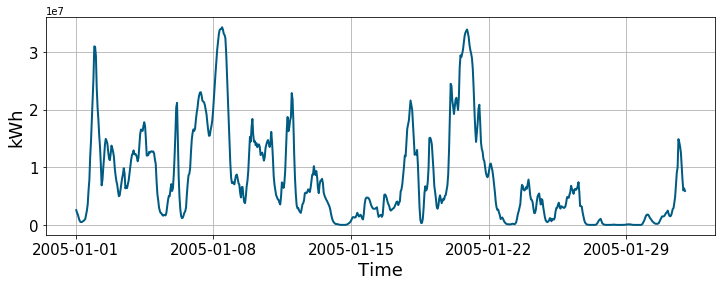

In [14]:
# Give a turbine name to each placement
locs = pd.DataFrame()
locs["lon"] = np.linspace(5.7,6.7,10000)             # latitude column MUST be given as 'lat'
locs["lat"] = np.linspace(50.4,51.0,10000)           # longitude column MUST be given as 'lon'
locs["hubHeight"] = np.linspace(49,52,10000)         # hub height column can be given, but must 
                                                     #  be named as 'hubHeight'
locs["powerCurve"] = ["E-126_EP4", "V136-3450"]*5000 # turbine name column can be given, but must
                                                     #  be named as either 'turbine' or 'powerCurve'
print("PLACEMENTS:")
print(locs.head(10))

print("\nSIMULATION:")
result = WindOnshoreWorkflow(locs, MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE, 
                             batchSize=BATCH_SIZE, jobs=JOBS)

tsplot(result)

PLACEMENTS:
      lon       lat  hubHeight     capacity  rotordiam
0  5.7000  50.40000    49.0000  3343.161518      120.0
1  5.7001  50.40006    49.0003  3555.683345      120.0
2  5.7002  50.40012    49.0006  3953.473002      120.0
3  5.7003  50.40018    49.0009  3450.838541      120.0
4  5.7004  50.40024    49.0012  3816.809819      120.0
5  5.7005  50.40030    49.0015  3090.774605      120.0
6  5.7006  50.40036    49.0018  3007.438763      120.0
7  5.7007  50.40042    49.0021  3216.555740      120.0
8  5.7008  50.40048    49.0024  3521.444439      120.0
9  5.7009  50.40054    49.0027  3570.177506      120.0

SIMULATION:
Starting at: 2017-12-06 15:17:27.836274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.07s
Convolving power curves at +1.22s
   Convolving 9 power curves...
Initializing simulations at +6.04s
Simulating 4 groups at +6.13s
Finished simulating 10000 turbines (10000 surviving) at +12.99s (769.82 turbines/sec)
Done at +12.99s!


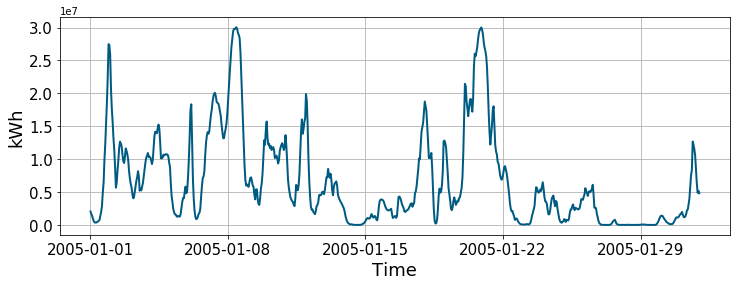

In [15]:
# Generate a synthetic pwoer curve for each placement
N = 10000
locs = pd.DataFrame()
locs["lon"] = np.linspace(5.7,6.7,N)        # latitude column MUST be given as 'lat'
locs["lat"] = np.linspace(50.4,51.0,N)      # longitude column MUST be given as 'lon'
locs["hubHeight"] = np.linspace(49,52,N)    # hub height column must be named as 'hubHeight'
locs["capacity"] = np.random.uniform(3000,4000,N) # capacity column must be named as 'capacity'
locs["rotordiam"] = np.ones(N)*120          # rotor diameter column must be named as 'rotordiam'

print("PLACEMENTS:")
print(locs.head(10))

print("\nSIMULATION:")
result2 = WindOnshoreWorkflow(locs, MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE, 
                             batchSize=BATCH_SIZE, jobs=JOBS)

tsplot(result2)

---
# Saving result as an output file
Options are:
* ".shp" -> As a shape file (only available when extracting the capacity factors)
* ".csv" -> As a csv file
* ".nc"  -> As a netCDF4 file

In [16]:
# Output to a CSV file
result = WindOnshoreWorkflow(locs, merra=MERRA_SOURCE, gwa=GWA_SOURCE, landcover=LAND_COVER_SOURCE,
                             powerCurve="V136-3450", hubHeight=100, output="example.csv",
                             batchSize=BATCH_SIZE, jobs=JOBS, verbose=VERBOSE, )

Starting at: 2017-12-06 15:17:41.009274
Arranging placements at +0.00s
Pre-loading windspeeds at +0.12s
Convolving power curves at +1.33s
Initializing simulations at +2.25s
Simulating 4 groups at +2.36s
Finished simulating 10000 turbines (10000 surviving) at +4.72s (2119.54 turbines/sec)
Writing output at +4.72s
Done at +4.73s!


In [17]:
# Look into the file...
with open("example.csv") as fin:
    for i in range(20):
        print(fin.readline()[:-1])

#### CONSTANTS ####
UnitCount,10000
lctype,clc
minCF,0
pcKey,V136-3450
hubHeight,100
capacity,3450.0
extract,totalProduction
units,kWh
#### RESULT-OUTPUT ####
time,production
2005-01-01 00:30:00+00:00,4047444.2392055043
2005-01-01 01:30:00+00:00,3329506.6197983716
2005-01-01 02:30:00+00:00,2826026.5360662644
2005-01-01 03:30:00+00:00,1969936.7328221537
2005-01-01 04:30:00+00:00,1253212.4580808422
2005-01-01 05:30:00+00:00,830912.2133760196
2005-01-01 06:30:00+00:00,742639.4823942854
2005-01-01 07:30:00+00:00,798934.1685978438
2005-01-01 08:30:00+00:00,972620.8422262641
